# PCA

In [1]:
import os
import torch
import json
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import BitsAndBytesConfig
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler

os.environ["CUDA_VISIBLE_DEVICES"]="0"

/home/nfs03/anaconda3/envs/zhMulti/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_hidden_states(model, input, tokenizer, device):
    model.eval()
    with torch.no_grad():
        input = tokenizer(input, return_tensors='pt')
        output = model(input.input_ids.to(device), attention_mask=input.attention_mask.to(device), output_hidden_states=True)

    # Tuple of  (batch_size, sequence_length, hidden_size)
    return output.hidden_states

In [3]:
def get_all_hidden_states(model, dataset:list, tokenizer, device):
    result = {}

    for data in tqdm(dataset):
        hidden_states = get_hidden_states(model, data, tokenizer, device)

        layer_num = model.config.num_hidden_layers
        for layer_id in range(layer_num + 1):
            vector_in_tensor = hidden_states[layer_id][0].to("cpu")
            vector_in_tensor = torch.mean(vector_in_tensor, dim=0)
            try:
                result[layer_id].append(vector_in_tensor)
            except:
                result[layer_id] = [vector_in_tensor]

    return result

In [4]:
class CustomDataset(Dataset):
    def __init__(self, json_path):
        with open(json_path, 'r') as f:
            self.data = json.load(f)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # 根据实际情况处理数据
        sample = self.data[idx]
        return sample

In [5]:
prompt_prefix = {'en': '''It starts off a bit slow, but once the product placement jokes start it takes off.
Emotion: "positive"             
I've read this book with much expectation, it was very boring all through out the book
Emotion: "negative"''',
                 'zh': '''一开始有点慢，但一旦植入式笑话开始，它就会起飞。
情感: "积极"
我带着很大的期待读了这本书，整本书都很无聊
情感: "消极"''',
                  'hi': '''इसकी शुरुआत थोड़ी धीमी होती है, लेकिन एक बार जब उत्पाद प्लेसमेंट के बारे में मजाक शुरू हो जाता है तो इसमें तेजी आ जाती है।
भावना: "सकारात्मक"
मैंने यह किताब बहुत उम्मीद के साथ पढ़ी है, पूरी किताब में यह बहुत उबाऊ थी
भावना: "नकारात्मक"''',
                  'de':'''Es fängt etwas langsam an, aber sobald die Witze über die Produktplatzierung beginnen, geht es los.
Emotion: "positiv"
Ich habe dieses Buch mit großer Erwartung gelesen, es war durchweg sehr langweilig
Emotion: "negativ"''',
                  'fr':'''Cela commence un peu lentement, mais une fois que les blagues sur le placement de produit commencent, cela décolle.
Émotion: "positif"
J'ai lu ce livre avec beaucoup d'attente, c'était très ennuyeux tout au long du livre
Émotion: "négatif"'''}

emotion_map = {'en':'Emotion: ', 'zh':'情感: ', 'hi':'भावना: ', 'de':'Emotion: ', 'fr':'Émotion: '}


def preprocess_data(data_path, language):
    data_list = []
    dataset = CustomDataset(data_path)
    assert(dataset is not None)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
    sample_iterator = tqdm(dataloader, desc="Inferenced batchs num")
    for step, inputs in enumerate(sample_iterator):
        text_item = prompt_prefix[language] + '\n' + inputs['input'][0] + '\n' + emotion_map[language] +  '\"'
        data_list.append(text_item)

    return data_list

In [6]:
def pca_decomp(data:list, n_components=2, if_save=False, save_dir=None, model_size=None, layer=0):
    
    # labels = torch.cat([
    #     torch.ones(100) * 1,
    #     torch.ones(100) * 2,
    #     torch.ones(100) * 3,
    #     torch.ones(100) * 4,
    #     # torch.ones(100) * 5,
    #     # torch.ones(100) * 6,
    #     # torch.ones(100) * 7,
    #     # torch.ones(100) * 8,
    #     # torch.ones(100) * 9,
    #     # torch.ones(100) * 10,
    # ], dim=0)

    input_vec = torch.stack(tensors=data, dim=0)
    pca = PCA(n_components=n_components)

    pca_result = pca.fit_transform(input_vec.numpy())

    plt.cla()


    # plt.colorbar()

    if if_save:
        plt.scatter(pca_result[:500, 0], pca_result[:500, 1], label="en")
        plt.scatter(pca_result[500:1000, 0], pca_result[500:1000, 1], label="de")
        plt.scatter(pca_result[1000:1500, 0], pca_result[1000:1500, 1], label="fr")
        plt.scatter(pca_result[1500:, 0], pca_result[1500:, 1], label="hi")

        plt.legend(fontsize=16)
        os.makedirs(f'{os.path.join(save_dir, model_size)}/PCA/emotion/2-shot/figures', exist_ok=True)
        plt.savefig(f'{os.path.join(save_dir, model_size)}/PCA/emotion/2-shot/figures/{model_size}_pca_{layer}.pdf', dpi=300, bbox_inches='tight')
    else:
        plt.scatter(pca_result[:500, 0], pca_result[:500, 1], label="en")
        plt.scatter(pca_result[500:1000, 0], pca_result[500:1000, 1], label="de")
        plt.scatter(pca_result[1000:1500, 0], pca_result[1000:1500, 1], label="fr")
        plt.scatter(pca_result[1500:, 0], pca_result[1500:, 1], label="hi")

        plt.legend(fontsize=16)
        plt.show()


In [7]:
def pca_decomp_seperate(data:list, n_components=2, if_save=False, save_dir=None, model_size=None, layer=0):
    
    # labels = torch.cat([
    #     torch.ones(100) * 1,
    #     torch.ones(100) * 2,
    #     torch.ones(100) * 3,
    #     torch.ones(100) * 4,
    #     # torch.ones(100) * 5,
    #     # torch.ones(100) * 6,
    #     # torch.ones(100) * 7,
    #     # torch.ones(100) * 8,
    #     # torch.ones(100) * 9,
    #     # torch.ones(100) * 10,
    # ], dim=0)

    input_vec = torch.stack(tensors=data, dim=0)
    pca = PCA(n_components=n_components)

    pca_result = pca.fit_transform(input_vec.numpy())

    plt.cla()

    # print((pca_result[:10, 0]).type)


    # plt.colorbar()

    if if_save:
        plt.scatter(np.concatenate((pca_result[:100*1, 0], pca_result[500:500+100*1, 0], pca_result[1000:1000+100*1, 0], pca_result[1500:1500+100*1, 0])), np.concatenate((pca_result[:100*1, 1], pca_result[500:500+100*1, 1], pca_result[1000:1000+100*1, 1], pca_result[1500:1500+100*1, 1])), label="0-100")
        plt.scatter(np.concatenate((pca_result[100*1:100*2, 0], pca_result[500+100*1:500+100*2, 0], pca_result[1000+100*1:1000+100*2, 0], pca_result[1500+100*1:1500+100*2, 0])), np.concatenate((pca_result[100*1:100*2, 1], pca_result[500+100*1:500+100*2, 1], pca_result[1000+100*1:1000+100*2, 1], pca_result[1500+100*1:1500+100*2, 1])), label="100-200")
        plt.scatter(np.concatenate((pca_result[100*2:100*3, 0], pca_result[500+100*2:500+100*3, 0], pca_result[1000+100*2:1000+100*3, 0], pca_result[1500+100*2:1500+100*3, 0])), np.concatenate((pca_result[100*2:100*3, 1], pca_result[500+100*2:500+100*3, 1], pca_result[1000+100*2:1000+100*3, 1], pca_result[1500+100*2:1500+100*3, 1])), label="200-300")
        plt.scatter(np.concatenate((pca_result[100*3:100*4, 0], pca_result[500+100*3:500+100*4, 0], pca_result[1000+100*3:1000+100*4, 0], pca_result[1500+100*3:1500+100*4, 0])), np.concatenate((pca_result[100*3:100*4, 1], pca_result[500+100*3:500+100*4, 1], pca_result[1000+100*3:1000+100*4, 1], pca_result[1500+100*3:1500+100*4, 1])), label="300-400")
        plt.scatter(np.concatenate((pca_result[100*4:100*5, 0], pca_result[500+100*4:500+100*5, 0], pca_result[1000+100*4:1000+100*5, 0], pca_result[1500+100*4:1500+100*5, 0])), np.concatenate((pca_result[100*4:100*5, 1], pca_result[500+100*4:500+100*5, 1], pca_result[1000+100*4:1000+100*5, 1], pca_result[1500+100*4:1500+100*5, 1])), label="400-500")

        plt.legend(fontsize=16)
        os.makedirs(f'{os.path.join(save_dir, model_size)}/PCA/emotion/2-shot/figures', exist_ok=True)
        plt.savefig(f'{os.path.join(save_dir, model_size)}/PCA/emotion/2-shot/figures/{model_size}_pca_{layer}.pdf', dpi=300, bbox_inches='tight')
    else:
        plt.scatter(np.concatenate((pca_result[:100*1, 0], pca_result[500:500+100*1, 0], pca_result[1000:1000+100*1, 0], pca_result[1500:1500+100*1, 0])), np.concatenate((pca_result[:100*1, 1], pca_result[500:500+100*1, 1], pca_result[1000:1000+100*1, 1], pca_result[1500:1500+100*1, 1])), label="0-100")
        plt.scatter(np.concatenate((pca_result[100*1:100*2, 0], pca_result[500+100*1:500+100*2, 0], pca_result[1000+100*1:1000+100*2, 0], pca_result[1500+100*1:1500+100*2, 0])), np.concatenate((pca_result[100*1:100*2, 1], pca_result[500+100*1:500+100*2, 1], pca_result[1000+100*1:1000+100*2, 1], pca_result[1500+100*1:1500+100*2, 1])), label="100-200")
        plt.scatter(np.concatenate((pca_result[100*2:100*3, 0], pca_result[500+100*2:500+100*3, 0], pca_result[1000+100*2:1000+100*3, 0], pca_result[1500+100*2:1500+100*3, 0])), np.concatenate((pca_result[100*2:100*3, 1], pca_result[500+100*2:500+100*3, 1], pca_result[1000+100*2:1000+100*3, 1], pca_result[1500+100*2:1500+100*3, 1])), label="200-300")
        plt.scatter(np.concatenate((pca_result[100*3:100*4, 0], pca_result[500+100*3:500+100*4, 0], pca_result[1000+100*3:1000+100*4, 0], pca_result[1500+100*3:1500+100*4, 0])), np.concatenate((pca_result[100*3:100*4, 1], pca_result[500+100*3:500+100*4, 1], pca_result[1000+100*3:1000+100*4, 1], pca_result[1500+100*3:1500+100*4, 1])), label="300-400")
        plt.scatter(np.concatenate((pca_result[100*4:100*5, 0], pca_result[500+100*4:500+100*5, 0], pca_result[1000+100*4:1000+100*5, 0], pca_result[1500+100*4:1500+100*5, 0])), np.concatenate((pca_result[100*4:100*5, 1], pca_result[500+100*4:500+100*5, 1], pca_result[1000+100*4:1000+100*5, 1], pca_result[1500+100*4:1500+100*5, 1])), label="400-500")

        plt.legend(fontsize=16)
        plt.show()


In [33]:
def pca_decomp_pearson(data:list, n_components=1, model_size=None, layer=0):
    
    print(f"Layer is {layer}")

    # labels = torch.cat([
    #     torch.ones(100) * 1,
    #     torch.ones(100) * 2,
    #     torch.ones(100) * 3,
    #     torch.ones(100) * 4,
    #     # torch.ones(100) * 5,
    #     # torch.ones(100) * 6,
    #     # torch.ones(100) * 7,
    #     # torch.ones(100) * 8,
    #     # torch.ones(100) * 9,
    #     # torch.ones(100) * 10,
    # ], dim=0)

    input_vec = torch.stack(tensors=data, dim=0)
    pca = PCA(n_components=n_components)

    pca_result = pca.fit_transform(input_vec.numpy())

    plt.cla()

    # print((pca_result[:10, 0]).type)


    # plt.colorbar()

    en = pca_result[:500, 0]
    de = pca_result[500:1000, 0]
    fr = pca_result[1000:1500, 0]
    hi = pca_result[1500:, 0]

    pearson_ende = np.corrcoef(en, de)[0, 1]
    pearson_enfr = np.corrcoef(en, fr)[0, 1]
    pearson_enhi = np.corrcoef(en, hi)[0, 1]
    pearson_defr = np.corrcoef(de, fr)[0, 1]
    pearson_dehi = np.corrcoef(de, hi)[0, 1]
    pearson_frhi = np.corrcoef(fr, hi)[0, 1]

    print(f"pearson_ende: {pearson_ende}")
    print(f"pearson_enfr: {pearson_enfr}")
    print(f"pearson_enhi: {pearson_enhi}")
    print(f"pearson_defr: {pearson_defr}")
    print(f"pearson_dehi: {pearson_dehi}")
    print(f"pearson_frhi: {pearson_frhi}")


In [39]:
model_size = 'mistral-7b'

all_avaliable_model = {'llama2-7b':'/home/nfs02/model/llama2/hf/Llama-2-7b-hf', 'llama2-13b':'/home/nfs02/model/llama2/hf/meta-llama_Llama-2-13b-hf', 
                       'llama2-7b-aligned':'/home/nfs03/zhangsm/multiL-transfer-interpretability/pretrained-models/llama2_zhjahi3k_round1_epoch12',
                       'llama2-13b':'/home/nfs02/llama2/hf/Llama-2-13b-hf',
                       'llama3-8b':'/home/nfs02/model/llama-3-8b',
                       'llama3-8b-aligned':'/home/nfs03/zhangsm/multiL-transfer-interpretability/pretrained-models/llama3-8b_emotion_zhes20k_round1_epoch3',
                       'mistral-7b':'/home/nfs02/model/mistralai_Mistral-7B-v0.1',
                       'mistral-7b-instructv0.2':'/home/nfs02/model/Mistral-7B-Instruct-v0.2',
                       'mistral-7b-aligned':'/home/nfs03/zhangsm/multiL-transfer-interpretability/pretrained-models/mistral_swhi20k_round1_epoch3',
                       'mistral-7b-tuned':'/home/nfs03/zhangsm/multiL-transfer-interpretability/pretrained-models/mistral_round2_epoch3',
                       'mistral-7b-tuned-aligned':'/home/nfs03/zhangsm/multiL-transfer-interpretability/pretrained-models/mistral_zhswgdbe40k_round12_epoch3',
                       'Qwen1.5-4b':'/home/nfs02/model/Qwen1.5-4B',
                       'Qwen1.5-4b-aligned':'/home/nfs03/zhangsm/multiL-transfer-interpretability/pretrained-models/Qwen4b_emotion_swbe20k_round1_epoch3',
                       'Qwen1.5-14b':'/home/nfs02/model/Qwen1.5-14B-Base',
                       'Qwen1.5-14b-aligned':'/home/nfs03/zhangsm/multiL-transfer-interpretability/pretrained-models/Qwen14b_emotion_zhde20k_round1_epoch3'}
model_name_or_path = all_avaliable_model[model_size]

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)

device = torch.device("cuda")

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_auth_token=None)
model = AutoModelForCausalLM.from_pretrained(model_name_or_path, use_auth_token=None, device_map='auto', quantization_config=quantization_config)
# model.to(device)
hidden_states = {}


for language in ["en", "de", "fr", "hi"]:
    data_path = "/home/nfs03/zhangsm/multiL-transfer-interpretability/zhangsm-multiL/data/ap_emotion/emotion_{}500_test.json".format(language)
    data_list = preprocess_data(data_path, language)

    hidden_states[language] = get_all_hidden_states(model, data_list, tokenizer, device)

100%|██████████| 500/500 [03:22<00:00,  2.47it/s]


Layer is 32
pearson_ende: 0.6608538878146463
pearson_enfr: 0.728393729798287
pearson_enhi: -0.06737416180488459
pearson_defr: 0.6962148828916844
pearson_dehi: -0.08623824739569996
pearson_frhi: -0.151507368148133


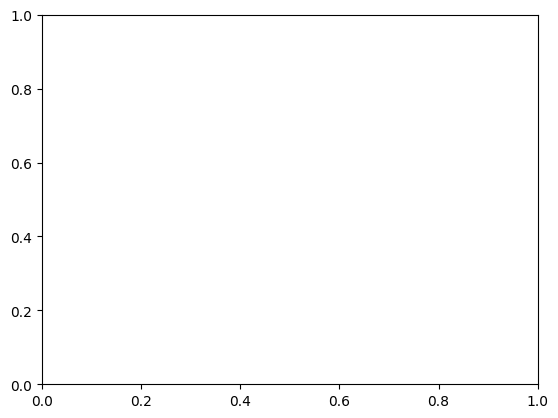

In [43]:
# get pca result
# layer = 32
# input_tensor = [
#     item for lang in ["en", "de", "fr", "hi"] for item in hidden_states[lang][layer][:500]
# ]

# pca_decomp(input_tensor, if_save=False, save_dir='../zsm-results', model_size=model_size, layer=layer)


# for layer in range(0, 41):
#     input_tensor = [
#         item for lang in ["en", "de", "fr", "hi"] for item in hidden_states[lang][layer][:500]
#     ]

#     pca_decomp(input_tensor, if_save=True, save_dir='./zsm-results', model_size=model_size, layer=layer)


# layer = 20
# input_tensor = [
#     item for lang in ["en", "de", "fr", "hi"] for item in hidden_states[lang][layer][:500]
# ]

# pca_decomp_seperate(input_tensor, if_save=False, save_dir='../zsm-results', model_size=model_size, layer=layer)


layer = 32
input_tensor = [
    item for lang in ["en", "de", "fr", "hi"] for item in hidden_states[lang][layer][:500]
]

pca_decomp_pearson(input_tensor, n_components=1, model_size=model_size, layer=layer)

# Reproducing

## locating language nerual

In [ ]:
def check_one_nerual(theta):